# EGS master catalogue
## Preparation of Canada France Hawaii Telescope WIRDS Survey (CFHT-WIRDS) data

The catalogue is in `dmu0_CFHT-WIRDS`.

In the catalogue, we keep:

- The position;
- The stellarity;
- The aperture magnitude (3 arcsec).
- The total magnitude (Kron like aperture magnitude).



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "wirds_ra"
DEC_COL = "wirds_dec"

## I - Column selection

In [4]:
#We have to import and combine the H, J and Ks catalogues separately. 
#Fluxes are given in counts sowe compute them fresh from the magnitudes

epoch = 2007



imported_columns = OrderedDict({
        'id': "wirds_id",
        'ra': "wirds_ra",
        'dec': "wirds_dec",
# ugriz are ks selected from cfhtls
#        'utot': "m_wirds_u",
#        'uterr': "merr_wirds_u",
#        'u': "m_ap_wirds_u",
#        'uerr': "merr_ap_wirds_u",
#        'gtot': "m_wirds_g",
#        'gterr': "merr_wirds_g",
#        'g': "m_ap_wirds_g",
#        'gerr': "merr_ap_wirds_g",
#        'rtot': "m_wirds_r",
#        'rterr': "merr_wirds_r",
#        'r': "m_ap_wirds_r",
#        'rerr': "merr_ap_wirds_r",
#        'itot': "m_wirds_i",
#        'iterr': "merr_wirds_i",
#        'i': "m_ap_wirds_i",
#        'ierr': "merr_ap_wirds_i",
#        'ztot': "m_wirds_z",
#        'zterr': "merr_wirds_z",
#        'z': "m_ap_wirds_z",
#        'zerr': "merr_ap_wirds_z",
        'jtot': "m_wirds_j",
        'jterr': "merr_wirds_j",
        'j': "m_ap_wirds_j",
        'jerr': "merr_ap_wirds_j",
        'htot': "m_wirds_h",
        'hterr': "merr_wirds_h",
        'h': "m_ap_wirds_h",
        'herr': "merr_ap_wirds_h",
        'kstot': "m_wirds_k",
        'ksterr': "merr_wirds_k",
        'ks': "m_ap_wirds_k",
        'kserr': "merr_ap_wirds_k"
        
    })


catalogue = Table.read("../../dmu0/dmu0_CFHT-WIRDS/data/EGS_Ks-priors.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        #catalogue_h[col].name = imported_columns_h[col]
        
        #catalogue[col][catalogue[col] <= -90.] = np.nan
        #catalogue[errcol][catalogue[errcol] <= -90.] = np.nan  
    
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
# Clean table metadata
catalogue.meta = None


/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:39: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** ((8.9 - magnitudes)/2.5)


In [5]:
catalogue.show_in_notebook()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = [#'merr_ap_wirds_u',
             #'merr_ap_wirds_g',
             #'merr_ap_wirds_r',
             #'merr_ap_wirds_i',
             #'merr_ap_wirds_z',
             'merr_ap_wirds_k',
            'merr_ap_wirds_j',
            'merr_ap_wirds_h']
FLAG_NAME = 'wirds_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 40385 sources.
The cleaned catalogue has 40385 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_EGS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

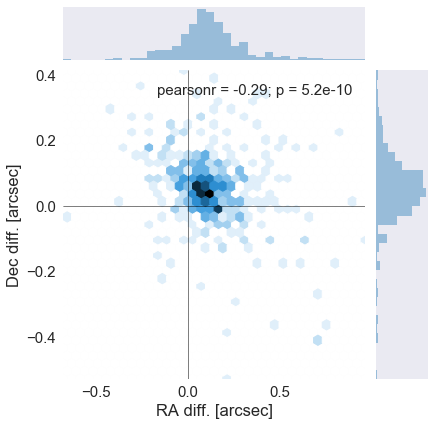

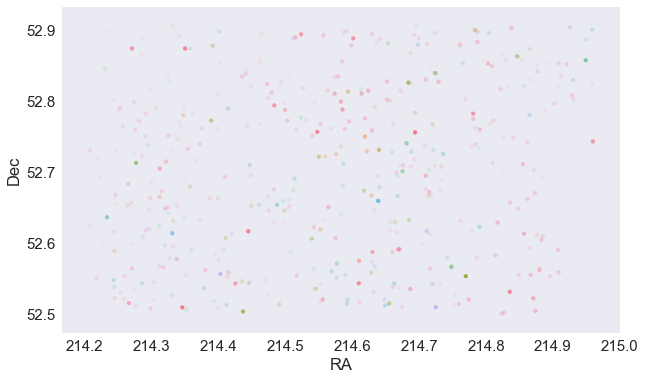

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL].to(u.deg), catalogue[DEC_COL].to(u.deg), 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.10571766479188227 arcsec
Dec correction: -0.05454708515912898 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] +=  delta_dec.to(u.deg)

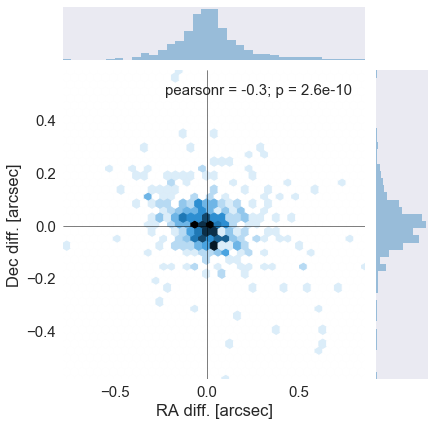

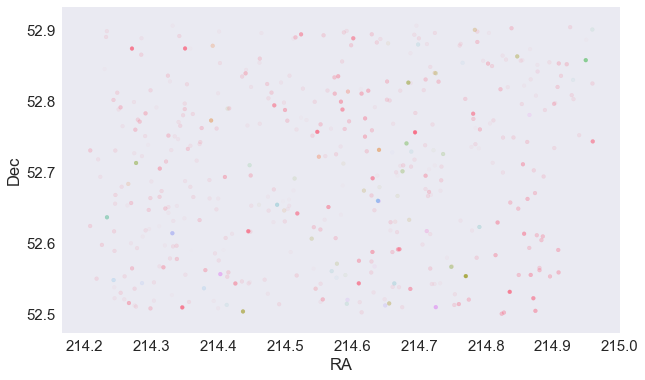

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "cfht-wirds_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

464 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/CFHT-WIRDS.fits".format(OUT_DIR), overwrite=True)